In [25]:
import os
import sys
import nltk
import math
import shlex
import itertools
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Series
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

In [26]:
data_folder_channels='/media/aruiz/data/channels_clean_data/'
fileName2=os.path.join(data_folder_channels,'all_channels_cat_clean.csv')
# fileName2=os.path.join(data_folder_channels,'gta_data_clean.csv')
df=pd.read_csv(fileName2)
df=df.sort_values(by=['views'],ascending=False)
df=df.fillna("N/A")
lemmatizer = WordNetLemmatizer()
stopWords = set(stopwords.words('english'))
searchKeys=["minecraft","roblox","call", "of", "duty","overwatch", "grand","theft","auto","league","legend",
            "Happy","wheel","five", "night", "at", "freddy's","agar.io", "pokemon"]
# searchKeys=["grand","theft","auto"]

/home/aruiz/.virtualenvs/LetsPlayData/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Frequent words (unigrams/bigrams)

In [27]:
# quartile3=246352
quartile3=42261 
all_keys_u=[] # all tag/words for each channel
all_keys_b=[] # all co-ocurrence of tags (bigrams)

for n in range(0,len(df)):
    if (df.keywords[n]!="N/A") and (df.views[n]>quartile3):
        channel_keys=[]
        
        try:
            l = shlex.split(df.keywords[n])

        except:
            l = df.keywords[n].split()
            
        for kw in l:
            kw_id = kw.lower().replace("'", "").replace("´", "").replace("’", "").replace("`", "")
            single_keys=nltk.word_tokenize(kw_id)
            for key in single_keys:
                key=lemmatizer.lemmatize(key)
                if (key not in stopWords)and(len(key)>1):
                    if (key not in channel_keys) and (key not in searchKeys):
                        channel_keys.append(key)
        
        for key in channel_keys:
            all_keys_u.append(key)
        
        edges= itertools.combinations(channel_keys,2)
        for edge in edges:
            t=(edge[0],edge[1])
            all_keys_b.append(t)
            
        df.loc[n,"num_tags"]=len(channel_keys)

In [17]:
counts_u=Series(all_keys_u)
cu=counts_u.value_counts()
counts_b=Series(all_keys_b)
cb=counts_b.value_counts()

# Tag co-ocurrence network

In [6]:
# adding nodes
g = nx.Graph()
for n in range (0,len(cu)):
    g.add_node(cu.index[n], type='keyword', weight=int(cu[n]))

In [7]:
# adding edges
for n in range (0,len(cb)):
    edge=cb.index[n]
    if g.has_edge(edge[0],edge[1]):
        g[edge[0]][edge[1]]['weight'] += cb[n]
    else:
        w=(cb[n])/math.sqrt(cu.loc[edge[0]]+cu.loc[edge[1]])
        g.add_edge(edge[0],edge[1], weight=float(w)) 

In [8]:
H=g.copy()
for n in range (1941,len(cu)):
    H.remove_node(cu.index[n])

In [9]:
let_ego=nx.ego_graph(H,'divertenti',radius=1)

In [10]:
nx.write_gexf(let_ego,"semantic1.gexf")

In [11]:
nx.draw_spring(let_ego,with_labels=True)

In [13]:
plt.savefig("ego1.png")

In [31]:
df

,id,title,description,year_created,month_created,views,subscribers,videos,comments,keywords,game_q,num_tags
42907,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,WWE on YouTube is your number one spot to catc...,2007,5,18860788591,20100862,32396,4769,"wrestling ""submission wrestling"" wwe ""व्यावसाय...",3,24.0
80604,UChGJGhZ9SOOHvBB0Y4DOO_w,Ryan ToysReview,Ryan loves Toys. Toys Review for kids by a ki...,2015,3,17634739090,10710148,905,0,"""toy reviews"" disney cars toys Lightning McQue...",5,17.0
4218,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,I make videos.,2010,4,15917181974,56785953,3264,289181,"pewdiepie pewds gaming ""felix arvid ulf""",6 7 2 9 0,6.0
132020,UCBnZ16ahKA2DZ_T5W0FPUXg,ChuChu TV Nursery Rhymes & Kids Songs,ChuChuTV is designed to engage children throug...,2013,2,12101336680,14103428,211,10,chuchutv nursery rhymes kids babies animation ...,9,27.0
89265,UCpko_-a4wgz2u_DgDgd9fqA,BuzzFeedVideo,BuzzFeed Motion Picture’s flagship channel. So...,2011,8,11790505377,14170097,4878,267,"""buzzfeed viral videos"" BuzzFeed ""BuzzFeed Vid...",6,9.0
6915,UCS5Oz6CHmeoF7vSad0qqXfw,DanTDM,Daily gaming videos with DanTDM :)\n\nBUSINESS...,2012,7,10713592663,16014868,2543,2014,minecraft roblox dantdm thediamondminecart dan...,9 6 7 1 0,12.0
6498,UCpGdL9Sn3Q5YWUH2DVUW1Ug,PopularMMOs,Your source for epic Minecraft content! Don't...,2012,4,9223733878,12349599,3744,578,"""minecraft map"" mini-game",2 7 0,2.0
188,UCaWd5_7JhbQBe4dknZhsHJg,WatchMojo.com,"Top 10 lists on Music, TV, Film and Video Game...",2007,1,8765392707,15079413,13182,168,"""top 10"" lists ""pop culture"" viral ""video game...",6 1 0,10.0
7337,UC7_YxT-KID8kRbqZo7MyscQ,Markiplier,Welcome to Markiplier! Here you'll find some h...,2012,5,7873776474,18159347,3795,15076,"markiplier gaming ""video games"" gameplay ""funn...",5 6 1 0,18.0
6362,UCKqH_9mk1waLgBiL2vT5b9g,VanossGaming,Official Vanoss Gaming YouTube Channel.,2011,9,7742700065,21144915,662,5053,Vanoss Funny Moments Fun GTA Gaming Gmod Garry...,2 8 7 4 6 0,11.0


# Save keywords txt

In [18]:
f= open ('keys_gta.txt','w')
for n in range (0,len(cu)):
    f.write(str(cu.index[n])+" "+str(cu[n]))

# Frequent words (trigrams)

In [74]:
# # English language filter
# i=0
# d=enchant.Dict('en_US')
# counts2=list(counts)
# counts_eng=[]
# for word in counts2:
#     if (d.check(word)):
#         del counts[word]
#         counts_eng.append(counts[word])

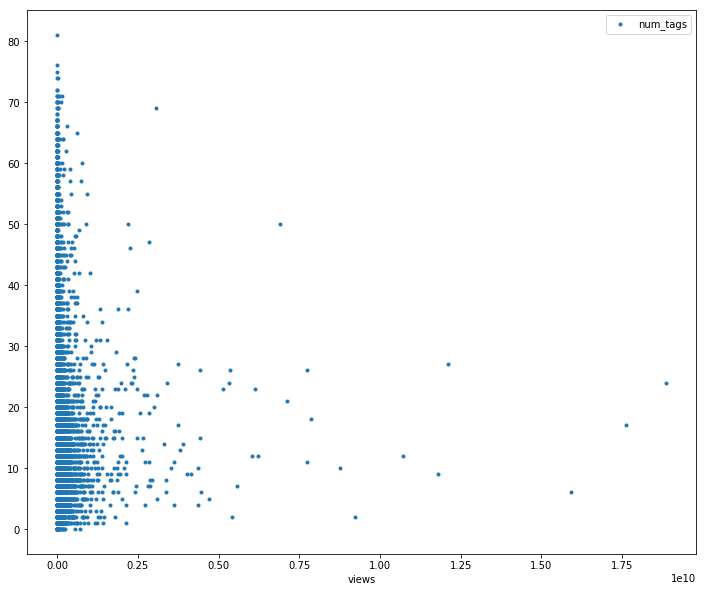

In [38]:
df.plot(x='views', y='num_tags', style='.', figsize=(12,10))

In [39]:
quartile3=42261 
all_keys_u=[] # all tag/words for each channel
all_keys_b=[] # all co-ocurrence of tags (bigrams)

for n in range(0,len(df)):
    if (df.description[n]!="N/A") and (df.views[n]>quartile3):
        channel_keys=[]
        
        try:
            l = shlex.split(df.description[n])

        except:
            l = df.description[n].split()
            
        for kw in l:
            kw_id = kw.lower().replace("'", "").replace("´", "").replace("’", "").replace("`", "")
            single_keys=nltk.word_tokenize(kw_id)
            for key in single_keys:
                key=lemmatizer.lemmatize(key)
                if (key not in stopWords)and(len(key)>1):
                    if (key not in channel_keys) and (key not in searchKeys):
                        channel_keys.append(key)
        
        for key in channel_keys:
            all_keys_u.append(key)
        
#         edges= itertools.combinations(channel_keys,2)
#         for edge in edges:
#             t=(edge[0],edge[1])
#             all_keys_b.append(t)
            
        df.loc[n,"num_unigrams"]=len(channel_keys)

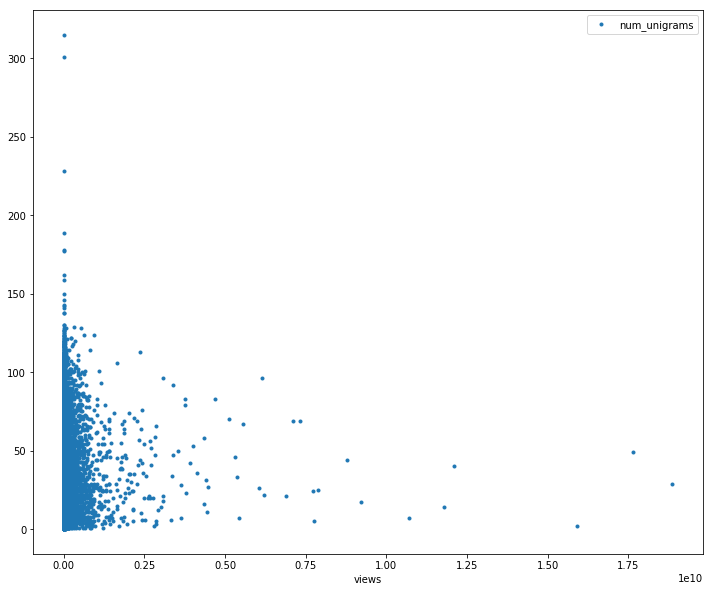

In [40]:
df.plot(x='views', y='num_unigrams', style='.', figsize=(12,10))